In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Problem: Manufacturing efficiency

A company operates $J = 5$ independent manufacturing lines, producing the same component. The efficiency of each line $j$, denoted by $\theta_j$, is the true (unknown) probability that a component produced by that line is flawless. We assume that these line efficiencies are *not* entirely independent; they are drawn from a common factory-wide distribution governed by overall parameters $\mu$ and $\tau$. We have the following data:

In [1]:
lines = [f"Line {i}" for i in range(1, 6)]
total_components = [50, 100, 20, 75, 150]
flawless_components = [45, 85, 19, 60, 140]

Model specification:
$$
\begin{aligned}
\mu & \sim N(0, 1) \\ 
\tau & \sim \text{Half-Cauchy} (0, 1) \\ 
\text{logit} (\theta_j) & \sim N(\mu, \tau^2) \\
k_j & \sim \text{Binomial}(N_j, \theta_j)
\end{aligned}
$$
where $k_j$ = number of flawless components produced by line $j$.

In [ ]:
with pm.Model(coords={"lines": lines}) as model:
    total_samples = pm.Data("total_samples", value=total_components)
    mu = pm.Normal("mu", mu=0, sigma=1)
    tau = pm.HalfCauchy("tau", beta=1.0)
    z = pm.Normal("z", mu=0, sigma=1, dims="lines")
    p = pm.Deterministic("p", pm.math.sigmoid(mu + z * tau), dims="lines")

    num_flawless = pm.Binomial(
        "flawless",
        n=total_samples,
        p=p,
        observed=flawless_components,
        dims="lines",
    )

    trace = pm.sample(2000, target_accept=0.95)
    prior_predictive = pm.sample_prior_predictive(1000)
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [flawless, mu, tau, z]
Sampling: [flawless]


Output()

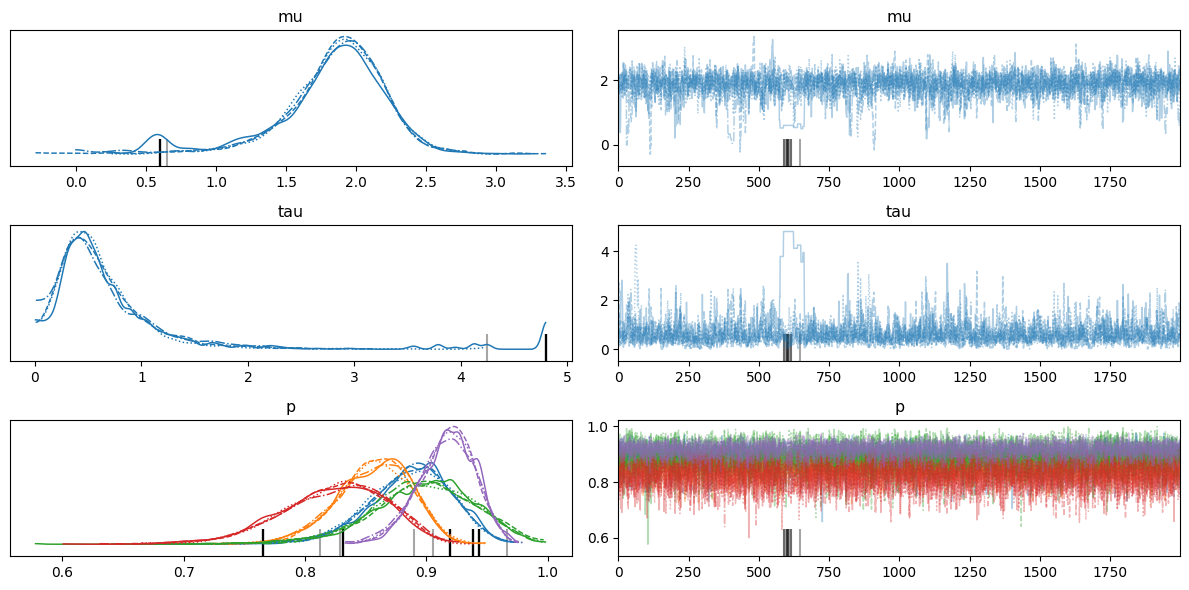

In [99]:
az.plot_trace(trace, var_names=["mu", "tau", "p"])
plt.tight_layout()
plt.show()

In [100]:
az.summary(trace, var_names=["mu", "tau", "p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.844,0.393,1.082,2.516,0.017,0.025,1028.0,337.0,1.00
tau,0.657,0.574,0.002,1.429,0.043,0.126,539.0,351.0,1.01
p[Line 1],0.886,0.035,0.822,0.949,0.000,0.000,6961.0,6283.0,1.00
p[Line 2],0.857,0.031,0.798,0.911,0.000,0.000,7244.0,6437.0,1.00
p[Line 3],0.896,0.044,0.818,0.977,0.001,0.001,4867.0,5206.0,1.00
p[Line 4],0.824,0.043,0.746,0.899,0.001,0.000,2846.0,4173.0,1.00
p[Line 5],0.916,0.023,0.873,0.958,0.000,0.000,3012.0,4639.0,1.00


In [ ]:
{
    line: flawless / total
    for line, total, flawless in zip(
        lines,
        total_components,
        flawless_components,
    )
}

{'Line 1': 0.9,
 'Line 2': 0.85,
 'Line 3': 0.95,
 'Line 4': 0.8,
 'Line 5': 0.9333333333333333}

In [ ]:
# trying to make predictions for a new line: Line 6
mu_samples = trace.posterior["mu"].values.flatten()
tau_samples = trace.posterior["tau"].values.flatten()
z_samples = np.random.normal(size=len(mu_samples))
logit_samples = mu_samples + z_samples * tau_samples
p_samples = 1.0 / (1.0 + np.exp(-logit_samples))

num_flawless_in_line6 = np.random.binomial(n=100, p=p_samples)

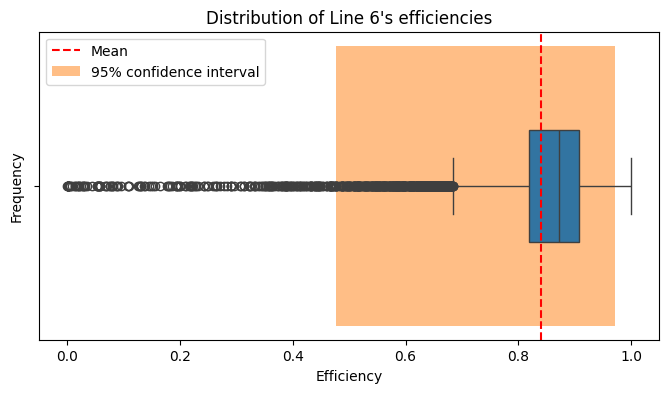

In [136]:
q2_5, q97_5 = np.quantile(p_samples, [0.025, 0.975])

plt.subplots(figsize=(8, 4))
sns.boxplot(x=p_samples)
plt.axvline(x=np.mean(p_samples), label="Mean", linestyle="--", color="red")

plt.fill_between(
    np.linspace(q2_5, q97_5, 100),
    -1,
    1,
    alpha=0.5,
    label="95% confidence interval",
)

plt.legend()
plt.title("Distribution of Line 6's efficiencies")
plt.xlabel("Efficiency")
plt.ylabel("Frequency")
plt.show()

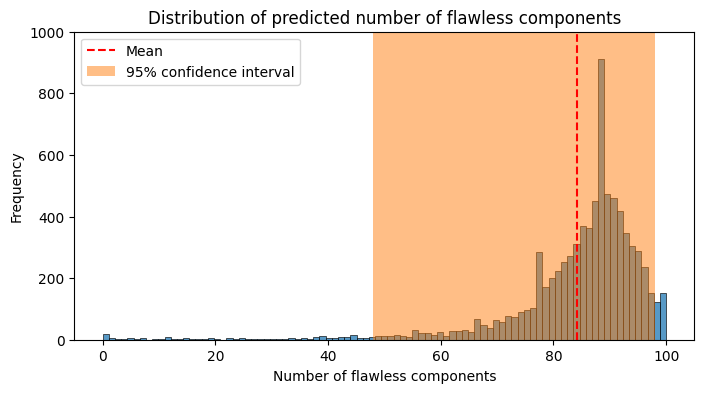

In [ ]:
q2_5, q97_5 = np.quantile(num_flawless_in_line6, [0.025, 0.975])

plt.subplots(figsize=(8, 4))
sns.histplot(x=num_flawless_in_line6)
plt.axvline(x=np.mean(num_flawless_in_line6), label="Mean", linestyle="--", color="red")

plt.fill_between(
    np.linspace(q2_5, q97_5, 100),
    0,
    1100,
    alpha=0.5,
    label="95% confidence interval",
)

plt.legend()
plt.ylim(0, 1000)
plt.title("Distribution of predicted number of flawless components")
plt.xlabel("Number of flawless components")
plt.ylabel("Frequency")
plt.show()

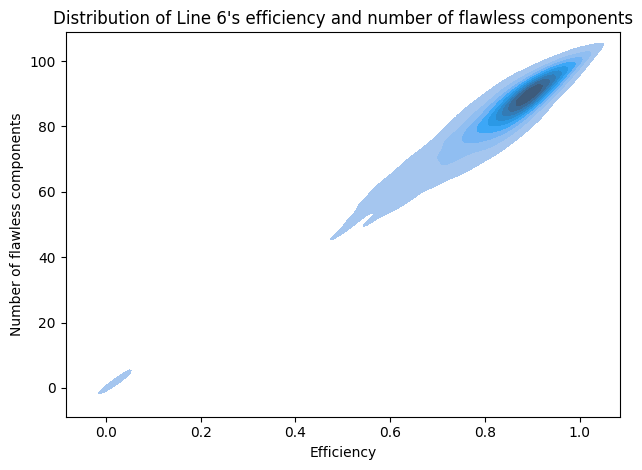

In [ ]:
sns.kdeplot(x=p_samples, y=num_flawless_in_line6, fill=True)

plt.title("Distribution of Line 6's efficiency and number of flawless components")
plt.xlabel("Efficiency")
plt.ylabel("Number of flawless components")

plt.tight_layout()
plt.show()